# Design Brief 

An insurance company wants to predict whether a person would have 'high' healthcare utilization. 

They want to use this in order to determine how much people should pay for their insurance.

Individuals with 'low' utilization will pay an X% of their salary for the insurance, while the price for those with a 'high' healthcare utilization score will be 2X% of their income. 

To complete the task, the company has provided you with the 2015 Consolidated Medical Expenditure data.

As in the previous use case that you have seen, I am asking you again to speak out loud while trying to explore the dataset and use-case to answer this question. 

You can of course use any tool that you would typically use, and you are also encouraged to also make use of the toolkit I just presented to you.

# Set-up

You first need to install the required libraries for the project. The main libraries are the aif360 and sklearn ones. We also recommend using numpy or pandas to easily manipulate and explore the data.

In [ ]:
!pip install aif360[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 8.8 MB/s 
     |████████████████████████████████| 21.2 MB 3.6 MB/s 
     |████████████████████████████████| 2.6 MB 42.0 MB/s 
     |████████████████████████████████| 1.3 MB 23.0 MB/s 
     |████████████████████████████████| 2.8 MB 3.0 MB/s 
     |████████████████████████████████| 275 kB 46.6 MB/s 
     |████████████████████████████████| 3.3 MB 22.3 MB/s 
     |████████████████████████████████| 34.5 MB 13 kB/s 
     |████████████████████████████████| 462 kB 49.7 MB/s 
     |████████████████████████████████| 564 kB 49.3 MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=99def0466db3e6651504bd60cf7873c725000d716d88c897646a08f30838b483
  Stored in directory: /root/.cache/pip/wheels/05/9f/ee/541a74be4cf5dad17430e64d3276370ea7b6a834a76cb4215a
  Created wheel for lime: filename=lime-

## Load required libraries

In [ ]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

#Sklearn fairness metrics
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

import seaborn as sns


np.random.seed(1)

# Dataset

Load the data.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/pablobiedma/datasets/main/dataset.csv")
# pd.set_option('display.max_columns', None)
df.head()

,REGION,AGE,SEX,RACE,MARRY,ACTDTY,HONRDC,RTHLTH,MNHLTH,HIBPDX,...,DFSEE42,ADSMOK42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F,WEIGHT
0,2,53,1,1,5,2,2,4,3,1,...,2,2,3,0,4,1,2,1,21854.98171,65.0
1,2,56,2,1,3,2,2,4,3,1,...,2,2,17,6,4,3,2,1,18169.60482,NaN
2,2,23,2,1,5,2,2,1,1,2,...,2,2,7,0,1,2,2,0,17191.83252,NaN
3,2,3,1,1,6,3,3,1,3,-1,...,2,-1,-1,-1,-1,2,2,0,20261.48546,58.0
4,3,27,1,0,1,1,4,2,1,2,...,2,-1,-1,-1,1,3,1,0,0.00000,51.0


In [ ]:
print("Number of records: " + str(df.shape[0]))
print("Number of features: " + str(df.shape[1]))

Number of records: 4400
Number of features: 41


## Dataset description

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181).

<!-- (as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192) ). -->
 
Other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).

To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring medical care by summing up the following features: the number of office based visits, the number of outpatient visits, the number of ER visits, the number of inpatient nights, and  the number of home health visits.
After summing up all these values, the feature was made cateorical, where a sum >= 10 resulted in the value 1 (considered 'high' utilization) and a sum < 10 in the value 0. 

<!-- (High utilization respondents constitute around 17% of each dataset.) -->

|features| description|
|---|---|
| RACE, AGE, SEX, REGION, MARRY | demographic features |
| ACTDTY, HONRDC | military service (active or discharge) |
| EMPST | employment status |
| POVCAT | poverty status |
| INSCOV | health insurance coverage indicator|
| PERWT15F | person-level weight - calculated based on region, <br> status, race, sex, age & poverty status| 
| HIBPDX | blood pressure|
| CHDDX, ANGIDX, MIDX, OHRTDX | heart diseases |
| STRKDX, EMPHDX, CHBRON, CHOLDX, CANCERDX, <br> DIABDX, JTPAIN, ARTHTYPE, ASTHDX, ADHDADDX | other specific diseases (eg. diabetes, cancer, asthma etc.) |
| PREGNT | pregnant status |
| ADSMOK42 | (non)smoker |
| WLKLIM | famility walking dificulties |
| ACTLIM, SOCLIM, COGLIM | work/school, social & cognitive limitations |
| DFHEAR42, DFSEE42 | hearing & visual impairment |
| PHQ242, K6SUM42, MNHLTH, RTHLTH | mental health-related information |
| UTILIZATION | healthcare utilization|

# Your exploration: 

# A1

In [ ]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

In [ ]:
pd_data = pd.DataFrame(dataset_orig_panel19_train.features, columns=dataset_orig_panel19_train.feature_names)
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

# A2




Data skew.

In [ ]:
print(df.skew())

REGION        -0.564462
AGE            0.280057
SEX           -0.024556
RACE           0.613524
MARRY         -0.100575
ACTDTY         0.817475
HONRDC         0.341628
RTHLTH         0.407700
MNHLTH         0.599832
HIBPDX        -0.702056
CHDDX         -0.935847
ANGIDX        -0.967602
MIDX          -0.956394
OHRTDX        -0.889475
STRKDX        -0.954164
EMPHDX        -0.975994
CHBRON        -0.962788
CHOLDX        -0.713876
CANCERDX      -0.900357
DIABDX        -0.882580
JTPAIN        -0.684413
ARTHDX        -0.747668
ARTHTYPE       1.775161
ASTHDX        -3.003633
ADHDADDX       1.229661
PREGNT         1.559013
WLKLIM        -3.277588
ACTLIM        -3.087928
SOCLIM        -6.197375
COGLIM        -0.924845
DFHEAR42      -5.191989
DFSEE42       -5.477891
ADSMOK42      -0.363021
K6SUM42        2.241126
PHQ242         2.349553
EMPST          0.245380
POVCAT        -0.454716
INSCOV         0.735618
UTILIZATION    1.727938
PERWT15F       3.077120
WEIGHT        -0.034082
dtype: float64


# A3


Examine sample sizes of groups according to race:

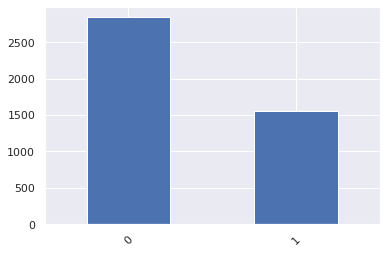

In [ ]:
df["RACE"].value_counts().plot(kind='bar', rot=45);

# A4 

In [ ]:
print(df["SEX"].value_counts()) # counts

2    2227
1    2173
Name: SEX, dtype: int64


# A5

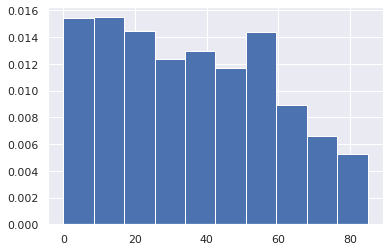

In [ ]:
df["AGE"].hist(density=1)

# A6

Examine how much the label frequencies vary within each group defined by race and sex:


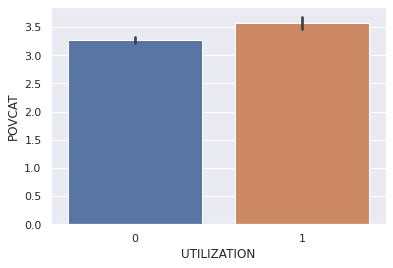

In [ ]:
sns.set()
sns.barplot(x="UTILIZATION", y="POVCAT", data=df, ci=95)


## A6.2

In [ ]:
#######

def getNormalizedCount(pd_train_data, protected_attribute, label):
    unnormalized_count = pd_train_data[[protected_attribute, label]].value_counts()
    counts = {}
    for attribute_value in pd_train_data[[protected_attribute]].value_counts().keys():
        counts[attribute_value[0]] = pd_train_data[[protected_attribute]].value_counts()[attribute_value]
    normalized_count = unnormalized_count[:]
    for attribute_value, utilization_value in pd_train_data[[protected_attribute, label]].value_counts().keys():
        normalized_count[attribute_value, utilization_value] = normalized_count[attribute_value, utilization_value] * (50 / counts[attribute_value])
    return normalized_count

# Balance of feature with their label.
pd_data["UTILIZATION"] = dataset_orig_panel19_train.labels

protected_attribute = "AGE"
label = "UTILIZATION"
print(getNormalizedCount(pd_data, protected_attribute, label))

protected_attribute = "RACE"
label = "UTILIZATION"
print(getNormalizedCount(pd_data, protected_attribute, label))

protected_attribute = "SEX=1"
label = "UTILIZATION"
print(getNormalizedCount(pd_data, protected_attribute, label))

protected_attribute = "SEX=2"
label = "UTILIZATION"
print(getNormalizedCount(pd_data, protected_attribute, label))

AGE   UTILIZATION
13.0  0.0            47
10.0  0.0            47
9.0   0.0            47
6.0   0.0            47
14.0  0.0            47
                     ..
22.0  1.0             3
9.0   1.0             2
11.0  1.0             2
8.0   1.0             1
3.0   1.0             0
Length: 172, dtype: int64
RACE  UTILIZATION
0.0   0.0            43
1.0   0.0            37
1.0   1.0            12
0.0   1.0             6
dtype: int64
SEX=1  UTILIZATION
1.0    0.0            43
0.0    0.0            39
0.0    1.0            10
1.0    1.0             6
dtype: int64
SEX=2  UTILIZATION
0.0    0.0            43
1.0    0.0            39
1.0    1.0            10
0.0    1.0             6
dtype: int64


# A7

               REGION       AGE       SEX      RACE     MARRY    ACTDTY  \
REGION       1.000000 -0.044567  0.022588 -0.120140  0.011745 -0.011883   
AGE         -0.044567  1.000000  0.073172  0.222487 -0.707474  0.309410   
SEX          0.022588  0.073172  1.000000 -0.011451 -0.051751  0.011689   
RACE        -0.120140  0.222487 -0.011451  1.000000 -0.184606  0.117538   
MARRY        0.011745 -0.707474 -0.051751 -0.184606  1.000000  0.003535   
ACTDTY      -0.011883  0.309410  0.011689  0.117538  0.003535  1.000000   
HONRDC       0.042901 -0.728660  0.008473 -0.181948  0.598865  0.141421   
RTHLTH      -0.025198  0.344514  0.072363  0.010076 -0.216952  0.079507   
MNHLTH      -0.018612  0.216507  0.038419  0.034807 -0.116147  0.045404   
HIBPDX      -0.036585  0.596337  0.053337  0.136499 -0.575276 -0.328479   
CHDDX       -0.041104  0.700425  0.062751  0.150865 -0.636527 -0.260801   
ANGIDX      -0.041643  0.719157  0.059540  0.153599 -0.643771 -0.241980   
MIDX        -0.042945  0.

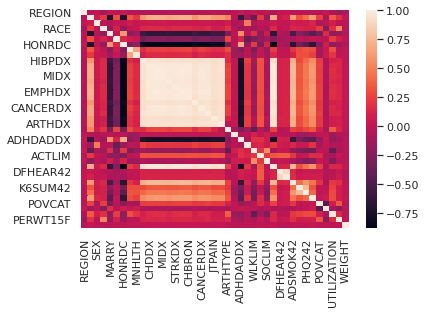

In [ ]:
print(df.corr())

sns.heatmap(df.corr());

Correlation with some key attributes:

In [ ]:
# Protected attribute:
protected_attributes_to_test = ['SEX=1', 'AGE', 'RACE']

correlation_dict = {}
for protected_attribute in protected_attributes_to_test:
    correlation_dict[protected_attribute] = []
    for feature in list(pd_data.columns):
        #print("Correlation between ", protected_attribute, " and ", feature, ": ", \
        #     pd_train_data[protected_attribute].corr(pd_train_data[feature]))
        correlation_dict[protected_attribute].append((feature, pd_data[protected_attribute].corr(pd_data[feature])))
        
for protected_attribute in protected_attributes_to_test:
    print("Correlation with ", protected_attribute, ":")
    print(sorted(correlation_dict[protected_attribute], key=lambda x: abs(x[1])))

Correlation with  SEX=1 :
[('ACTLIM=-1', -0.0006069847699958325), ('POVCAT=3', -0.0007547185764938877), ('MARRY=10', 0.0012991301230315638), ('REGION=1', -0.002060943812819198), ('EMPST=3', -0.0023246444046163594), ('CHDDX=1', -0.002807136285812437), ('MARRY=7', 0.0028367750880002587), ('PHQ242=0', 0.0035060794504265867), ('REGION=2', 0.0038189030935651173), ('EMPST=2', -0.0040056989999773755), ('MNHLTH=2', -0.0040542368939938045), ('ACTDTY=2', 0.004253226782119774), ('HIBPDX=1', -0.0061165604273762395), ('POVCAT=2', -0.006357217528307371), ('JTPAIN=2', 0.006452165197777171), ('FTSTU=2', 0.006526304170814044), ('REGION=3', 0.006556514990586878), ('PHQ242=5', -0.007773397578611309), ('RTHLTH=-1', -0.008659055747700232), ('MNHLTH=-1', -0.008659055747700232), ('WLKLIM=-1', -0.008659055747700232), ('SOCLIM=-1', -0.008659055747700232), ('REGION=4', -0.008743986414552636), ('DFHEAR42=1', 0.008797210569449493), ('DFHEAR42=-1', 0.008916407164397648), ('DFSEE42=-1', 0.008916407164397648), ('FTS

# A8 

In [ ]:
print("Number of missing values for each attribute: ", df.isnull().sum())

Number of missing values for each attribute:  REGION           0
AGE              0
SEX              0
RACE             0
MARRY            0
ACTDTY           0
HONRDC           0
RTHLTH           0
MNHLTH           0
HIBPDX           0
CHDDX            0
ANGIDX           0
MIDX             0
OHRTDX           0
STRKDX           0
EMPHDX           0
CHBRON           0
CHOLDX           0
CANCERDX         0
DIABDX           0
JTPAIN           0
ARTHDX           0
ARTHTYPE         0
ASTHDX           0
ADHDADDX         0
PREGNT           0
WLKLIM           0
ACTLIM           0
SOCLIM           0
COGLIM           0
DFHEAR42         0
DFSEE42          0
ADSMOK42         0
K6SUM42          0
PHQ242           0
EMPST            0
POVCAT           0
INSCOV           0
UTILIZATION      0
PERWT15F         0
WEIGHT         790
dtype: int64


## A8.2

In [ ]:
df = df.dropna()

In [ ]:
print("Number of missing values for each attribute: ", df.isnull().sum())

Number of missing values for each attribute:  REGION         0
AGE            0
SEX            0
RACE           0
MARRY          0
ACTDTY         0
HONRDC         0
RTHLTH         0
MNHLTH         0
HIBPDX         0
CHDDX          0
ANGIDX         0
MIDX           0
OHRTDX         0
STRKDX         0
EMPHDX         0
CHBRON         0
CHOLDX         0
CANCERDX       0
DIABDX         0
JTPAIN         0
ARTHDX         0
ARTHTYPE       0
ASTHDX         0
ADHDADDX       0
PREGNT         0
WLKLIM         0
ACTLIM         0
SOCLIM         0
COGLIM         0
DFHEAR42       0
DFSEE42        0
ADSMOK42       0
K6SUM42        0
PHQ242         0
EMPST          0
POVCAT         0
INSCOV         0
UTILIZATION    0
PERWT15F       0
WEIGHT         0
dtype: int64


# A9

In [ ]:
print(df.duplicated().sum())

668


## A9.2.

In [ ]:
pd_data = pd_data.drop_duplicates()

In [ ]:
print(pd_data.duplicated().sum())

0


# A10

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


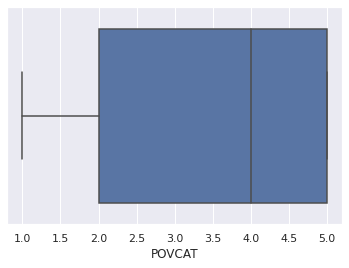

In [ ]:
# PERWT15F = person level weight (region, status, race, sex, age, poverty status)
sns.boxplot(df['POVCAT'])

# B1

We train a logistic regression model and save its predictions on test data for analysis.

In [ ]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

NameError: ignored

Metrics for original data

In [ ]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


# B2 


In [ ]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
        metric_arrs['bal_acc'].append((metric.true_positive_rate()+ metric.true_negative_rate()) / 2)
        metric_arrs['theil_index'].append(metric.theil_index())
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disparate_impact'].append(metric.disparate_impact())
        metric_arrs['statistical_parity_difference'].append(metric.statistical_parity_difference())        
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['accuracy'].append(metric.accuracy())
        metric_arrs['precision'].append(metric.precision(True))
        metric_arrs['recall'].append(metric.recall(True)) 
        metric_arrs['num_TP'].append(metric.num_true_positives())
        metric_arrs['num_FP'].append(metric.num_false_positives())
        metric_arrs['num_TN'].append(metric.num_true_negatives())
        metric_arrs['num_FN'].append(metric.num_false_negatives())
        metric_arrs['positive_predictive_value'].append(metric.positive_predictive_value(True))
        metric_arrs['negative_predictive_value'].append(metric.negative_predictive_value(True))
        metric_arrs['false_negative_rate_difference'].append(metric.false_negative_rate_difference())
        metric_arrs['false_positive_rate_difference'].append(metric.false_positive_rate_difference()) 
        metric_arrs['proba_positive_prot'].append(metric.num_pred_positives(True)/metric.num_instances(True))

    return metric_arrs

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

# B3 

Make a function to print out accuracy and fairness metrics. This will be used throughout the notebook.

In [ ]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    disp_imp_at_best_ind = 1 - min(metrics['disparate_impact'][best_ind], 1/metrics['disparate_impact'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['statistical_parity_difference'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_index'][best_ind]))

In [ ]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


In [ ]:
test_metric = test(dataset_orig_panel19_test, model, [0.19])
print("TP: ", test_metric["num_TP"][0])
print("TN: ", test_metric["num_TN"][0])
print("FP: ", test_metric["num_FP"][0])
print("FN: ", test_metric["num_FN"][0])

TP:  4698949.946001999
TN:  16634655.868956
FP:  4887526.895591
FN:  1333365.5122969998


In [ ]:
print("Precision : TP / (TP + FP) = ", test_metric["num_TP"][0] / (test_metric["num_TP"][0] + test_metric["num_FP"][0]))
print("Recall : TP / (TP + FN) = ", test_metric["num_TP"][0] / (test_metric["num_TP"][0] + test_metric["num_FN"][0]))
print("Error : (FP + FN) / (TP + TN + FP + FN) = ", (test_metric["num_FP"][0] + test_metric["num_FN"][0]) / (test_metric["num_TP"][0] + test_metric["num_FN"][0] + test_metric["num_TN"][0] + test_metric["num_FP"][0]))
print("Performance or Accuracy : 1 - Error = ", 1 - (test_metric["num_FP"][0] + test_metric["num_FN"][0]) / (test_metric["num_TP"][0] + test_metric["num_FN"][0] + test_metric["num_TN"][0] + test_metric["num_FP"][0]))


Precision : TP / (TP + FP) =  0.4901644288769979
Recall : TP / (TP + FN) =  0.7789629004791828
Error : (FP + FN) / (TP + TN + FP + FN) =  0.22576685510934583
Performance or Accuracy : 1 - Error =  0.7742331448906542


In [ ]:

print("Positive predictive value difference: ", test_metric['positive_predictive_value'][0] - test_metric['positive_predictive_value'][0])
print("Negative predictive value difference: ", test_metric['negative_predictive_value'][0] - test_metric['negative_predictive_value'][0])
print("False negative rate difference: ", test_metric['false_negative_rate_difference'][0])
print("False positive rate difference: ", test_metric['false_positive_rate_difference'][0])
print("Disparate impact: ", test_metric['disparate_impact'][0])
print("Statistical parity difference: ", test_metric['statistical_parity_difference'][0])

Positive predictive value difference:  0.0
Negative predictive value difference:  0.0
False negative rate difference:  0.2227794917646236
False positive rate difference:  -0.18863299930971128
Disparate impact:  0.42617612547690836
Statistical parity difference:  -0.26120731043996515


# C1

## C1.2

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

Metrics for transformed data:

In [ ]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


## C1.3

Training LR model after reweighing

In [ ]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

Validating LR model after reweighing

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7581
Corresponding 1-min(DI, 1/DI) value: 0.2939
Corresponding average odds difference value: -0.0084
Corresponding statistical parity difference value: -0.0992
Corresponding equal opportunity difference value: 0.0242
Corresponding Theil index value: 0.0938


Testing LR model after reweighing

In [ ]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [ ]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7539
Corresponding 1-min(DI, 1/DI) value: 0.2482
Corresponding average odds difference value: -0.0151
Corresponding statistical parity difference value: -0.0872
Corresponding equal opportunity difference value: -0.0035
Corresponding Theil index value: 0.0966


# C2

Training a PR model

In [ ]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_panel19_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

Validating a PR model

In [ ]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_panel19_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6836
Corresponding 1-min(DI, 1/DI) value: 0.2262
Corresponding average odds difference value: 0.0256
Corresponding statistical parity difference value: -0.0828
Corresponding equal opportunity difference value: 0.1172
Corresponding Theil index value: 0.1119


Testing PR model

In [ ]:
dataset = dataset_orig_panel19_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_panel19,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [ ]:
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6880
Corresponding 1-min(DI, 1/DI) value: 0.1588
Corresponding average odds difference value: 0.0523
Corresponding statistical parity difference value: -0.0566
Corresponding equal opportunity difference value: 0.1479
Corresponding Theil index value: 0.1108


# D1 

In [ ]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics, pr_orig_metrics]
debias = pd.Series(['Unaware']+['Reweighing']+['Prejudice Remover'], name='Bias Mitigator')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias])

,bal_acc,theil_index,avg_odds_diff,disparate_impact,statistical_parity_difference,eq_opp_diff,accuracy,precision,recall,num_TP,num_FP,num_TN,num_FN,positive_predictive_value,negative_predictive_value,false_negative_rate_difference,false_positive_rate_difference,proba_positive_prot
Bias Mitigator,,,,,,,,,,,,,,,,,,
Unaware,0.775935,0.092122,-0.205706,0.426176,-0.261207,-0.222779,0.774233,0.500682,0.838824,4.698950e+06,4.887527e+06,1.663466e+07,1.333366e+06,0.500682,0.919617,0.222779,-0.188633,0.455205
Reweighing,0.753893,0.096575,-0.015104,0.751755,-0.087196,-0.003518,0.777413,0.551530,0.712999,4.295335e+06,4.396305e+06,1.712588e+07,1.736981e+06,0.551530,0.879800,0.003518,-0.026689,0.351252
Prejudice Remover,0.688028,0.110774,0.052286,0.841229,-0.056631,0.147869,0.722252,0.447470,0.587415,3.783150e+06,5.404035e+06,1.611815e+07,2.249166e+06,0.447470,0.825745,-0.147869,-0.043297,0.356681
